In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import torch
import torch.nn as nn
import re
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
from sklearn.model_selection import train_test_split
import shutil

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


## Importing data

In [ ]:
data_v1= pd.read_json("/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/Sarcasm_Headlines_Dataset.json",lines=True)
data_v2= pd.read_json("/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/Sarcasm_Headlines_Dataset_v2.json",lines=True)

In [ ]:
data_v1.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [ ]:
print ("data v1 columns :", data_v1.columns)
print ("data v2 columns :", data_v1.columns)

data v1 columns : Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')
data v2 columns : Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')


## EDA

In [ ]:
sarcastic_data_v1_counts=data_v1.is_sarcastic.value_counts()
sarcastic_data_v2_counts= data_v2.is_sarcastic.value_counts()


In [ ]:
sarcasm_count_v1= sarcastic_data_v1_counts[1]
non_sarcastic_count_v1= sarcastic_data_v1_counts[0]
ratio_sarc_nonsarc_v1 = sarcasm_count_v1 / non_sarcastic_count_v1

print (f"number of sarcastic comments in v1={sarcasm_count_v1}")
print (f"number of non-sarcastic comments in v1={non_sarcastic_count_v1}")
print(f"ratio: {ratio_sarc_nonsarc_v1}")

number of sarcastic comments in v1=11724
number of non-sarcastic comments in v1=14985
ratio: 0.7823823823823823


In [ ]:
sarcasm_count_v2= sarcastic_data_v2_counts[1]
non_sarcastic_count_v2= sarcastic_data_v2_counts[0]
ratio_sarc_nonsarc_v2 = sarcasm_count_v2 / non_sarcastic_count_v2

print (f"number of sarcastic comments in v2={sarcasm_count_v2}")
print (f"number of non-sarcastic comments in v2={non_sarcastic_count_v2}")
print(f"ratio: {ratio_sarc_nonsarc_v2}")

number of sarcastic comments in v2=13634
number of non-sarcastic comments in v2=14985
ratio: 0.9098431765098431


In [ ]:
print ("""
V2 DATASET IS MORE BALANCED
""")


V2 DATASET IS MORE BALANCED



In [ ]:
sarcasm_v1 = data_v1.loc[data_v1.is_sarcastic==1]
non_sarcasm_v1 = data_v1.loc[data_v1.is_sarcastic==0]

sarcasm_v2 = data_v2.loc[data_v2.is_sarcastic==1]
non_sarcasm_v2 = data_v2.loc[data_v2.is_sarcastic==0]

In [ ]:
#check if v2 and v1 have repetitive data
sarc_common_comment=[]
non_sarc_common_comment=[]
for comment in sarcasm_v1.headline.values :
    if comment in sarcasm_v2.headline.values:
        sarc_common_comment.append(comment)
print("number of common sarcastic comments = ", sarc_common_comment.__len__() )

for comment in non_sarcasm_v1.headline.values :
    if comment in non_sarcasm_v2.headline.values:
        non_sarc_common_comment.append(comment)
print("number of common sarcastic comments = ", non_sarc_common_comment.__len__() )

number of common sarcastic comments =  11724
number of common sarcastic comments =  14985


In [ ]:
print ("""
Number of common sarcastic comments is the same as total number of sarcastic comments in V1.
Number of common non sarcastic comments is the same as total number of non sarcastic comments in V1.

It's enough information to conclude that V2 dataset just has more sarcastic comments than V1 dataset's.

Henceforth, use only V2 dataset.
""")


Number of common sarcastic comments is the same as total number of sarcastic comments in V1.
Number of common non sarcastic comments is the same as total number of non sarcastic comments in V1.

It's enough information to conclude that V2 dataset just has more sarcastic comments than V1 dataset's.

Henceforth, use only V2 dataset.



In [ ]:
data= data_v2.iloc[:,:-1] #'article link' column isn't required
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [ ]:
sarcastic_df = data.loc[data.is_sarcastic==1]
not_sarcastic_df = data.loc[data.is_sarcastic==0]

In [ ]:
sarc_commentsList = sarcastic_df['headline'].astype(str).tolist()
notSarc_commentsList = not_sarcastic_df['headline'].astype(str).tolist()

In [ ]:
def countSymbols(commentsList,typename):
    symbolList= ",.\"\'!@#$%^&*(){}?/;`~:<>+=-"
    symCountDict= {'Symbols':[],'Count':[],'Type':[]}
    for symbol in symbolList:
        symCountDict['Symbols'].append(symbol)
        symCountDict['Count'].append (sum([comm.count(symbol) for comm in commentsList]))
        symCountDict['Type'].append(typename)
    return symCountDict

In [ ]:
sarcSymCount= countSymbols(sarc_commentsList, 'sarcastic')
non_sarcSymCount=countSymbols(notSarc_commentsList,'not_sarcastic')

In [ ]:
sarcdf= pd.DataFrame(sarcSymCount)
nonsarcdf= pd.DataFrame(non_sarcSymCount)

In [ ]:
allsarcdf = sarcdf.append(nonsarcdf)
allsarcdf.head()

,Symbols,Count,Type
0,",",1756,sarcastic
1,.,886,sarcastic
2,"""",15,sarcastic
3,',5506,sarcastic
4,!,39,sarcastic


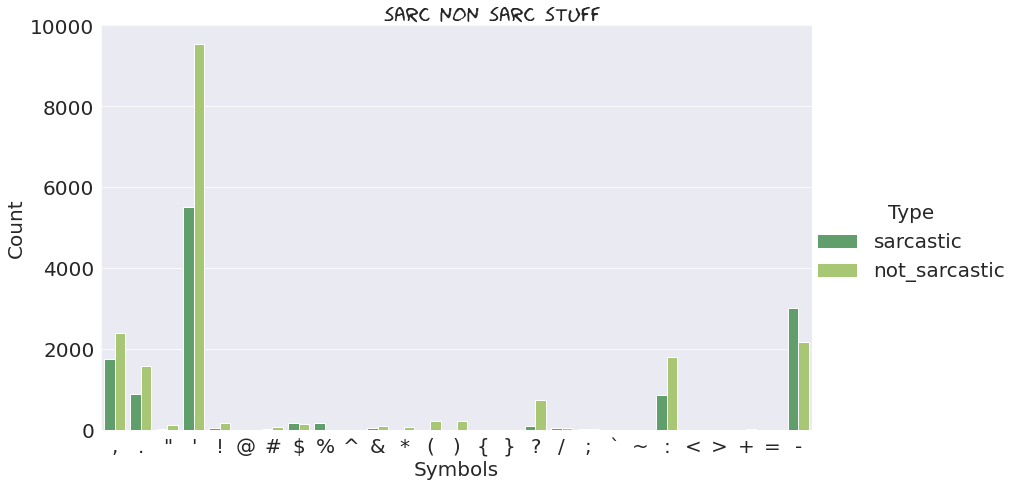

In [ ]:
sns.set_style('darkgrid')
#style.use('dark_background')
matplotlib.rcParams['font.size']='20'
matplotlib.rcParams['axes.labelsize']='20'
plot= sns.catplot(
    x='Symbols',
    y= 'Count' ,
    data=allsarcdf,
    hue='Type',
    kind='bar',
    palette='summer',
    height=7,
    aspect=12/7,
    legend=True,
    margin_titles=False,
)

plot.fig.suptitle("sarc non sarc stuff",
                  fontsize=20,fontfamily= 'fantasy');

## Cleaning

In [ ]:
data.isnull().sum()

is_sarcastic    0
headline        0
dtype: int64

In [ ]:
print ( " NO NULL ENTRIES")

 NO NULL ENTRIES


In [ ]:
def clean_text(text):

    text = text.lower()

    pattern = re.compile('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    text = pattern.sub('', text)
    text = " ".join(filter(lambda x:x[0]!='@', text.split()))
    emoji = re.compile("["
                           u"\U0001F600-\U0001FFFF"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)

    text = emoji.sub(r'', text)
    text = text.lower()

    text = re.sub(r"i'm", "i am", text)
    text = re.sub(r" im |^im", "where is", text)

    text = re.sub(r"he's", "he is", text)
    text = re.sub(r" hes |^hes", "he is", text)

    text = re.sub(r"she's", "she is", text)
    text = re.sub(r" shes |^shes", "she is", text)

    text = re.sub(r"that's", "that is", text)
    text = re.sub(r" thats |^thats", "that is", text)

    text = re.sub(r"what's", "what is", text)
    text = re.sub(r" whats |^whats", "what is", text)

    text = re.sub(r"where's", "where is", text)
    text = re.sub(r" wheres |^wheres", "where is", text)

    text = re.sub(r"ain't", "is not", text)
    text = re.sub(r" aint |^aint", "is not", text)

    text = re.sub(r"won't", "will not", text)
    text = re.sub(r" wont |^wont", "will not", text)

    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r" wasnt |^wasnt", "was not", text)

    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r" hasnt |^hasnt", "has not", text)

    text = re.sub(r"don't", "do not", text)
    text = re.sub(r" dont |^dont", "do not", text)

    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r" didnt |^didnt", "did not", text)

    text = re.sub(r"can't", "can not", text)
    text = re.sub(r" cant |^cant", "can not", text)

    text = re.sub(r"it's", "it is", text)
    text = re.sub(r" its |^its", "it is", text)

    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r" coudlnt |^couldnt", "could not", text)

    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r" havent |^havent", "have not", text)

    text = re.sub(r" theyre |^theyre", "they are", text)

    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"n't", " not", text)

    #based on EDA, symbols{' : ? - } should be preserved
    text = re.sub(r"[.!,\"@#$%^&*(){}/;`~<>+=]", " ", text)
    """
    rather than subbing with "", it's better to sub with " ", to show that there was something there,
    not necessarily useful, but not worth nothing either. Situations in which 2 words are separated by , or - for example,
    would retain their form as individual words. Subbing with "" would cause them to effectively get concatenated, which
    might result in some unknown token unnecessarily.
    """
    return text

In [ ]:
def clean_data(df):
    sent = { 'comment': [] ,'label': [] }
    for row in df.values:
        assert type (row[1]) == str , f"{row[1]}"
        sent['comment'].append(clean_text(row[1]) )
        sent['label'].append(row[0])
    return sent

In [ ]:
train_dict = clean_data(data)

In [ ]:
training_examples= pd.DataFrame(train_dict, columns=['comment', 'label'])

In [ ]:
training_examples.head()

,comment,label
0,thirtysomething scientists unveil doomsday clo...,1
1,dem rep totally nails why congress is falling...,0
2,eat your veggies: 9 deliciously different recipes,0
3,inclement weather prevents liar from getting t...,1
4,mother comes pretty close to using word 'strea...,1


In [ ]:
training_examples.shape

(28619, 2)

## Data split

In [ ]:
#use only a fraction of the training data:
train_df, test_df = train_test_split(training_examples, train_size= 0.8, stratify = training_examples.label)

In [ ]:
train_df, val_df = train_test_split(train_df, train_size= 0.75, stratify = train_df.label)

In [ ]:
#SPLIT RATIO:
#train : 60%, test: 20%, val: 20%
len(train_df), len(test_df) , len(val_df)

(17171, 5724, 5724)

## Tokenization, embeddings and Dataset Class


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.4 MB 5.3 MB/s 
     |████████████████████████████████| 101 kB 11.0 MB/s 
     |████████████████████████████████| 596 kB 64.2 MB/s 
     |████████████████████████████████| 6.6 MB 53.6 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import BertTokenizer

In [ ]:
MAX_LENGTH = 50

In [ ]:
bert_tokenizer= BertTokenizer.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_length, isbert=False):
        self.text= df['comment'].astype(str).tolist()
        self.tokenizer= tokenizer
        self.labels= df.label.values
        self.max_length = max_length
        self.isbert= isbert
    def __len__(self):
        return self.text.__len__()
    def __getitem__(self,index):
        """
        FOR BERT:
        #start with CLS_TOKEN
        tokenized_text= [CLS_TOKEN]
        tokenized_text.append (self.tokenizer(self.text[index]) )
        #add SEP_TOKEN
        tokenized_text.append(SEP_TOKEN)
        """
        if not self.isbert:
            tokenized_text= self.tokenizer(self.text[index])
            #add padding using PAD_TOKEN

            length_diff= self.max_length-tokenized_text.__len__()

            if length_diff >= 0 :
                tokenized_text.extend([PAD_TOKEN]*length_diff)
            else: #truncate if length_diff is negative, i.e, tokenized_text should not be longer than max length
                tokenized_text = tokenized_text[:length_diff]

            #ensure all token lists are of equal length
            assert len(tokenized_text)== self.max_length, f"text:{tokenized_text}\nlendif:{length_diff}\nlength of tokenized text({len(tokenized_text)}) != {self.max_length} after padding"

            #For GloVe embeddings:
            vecs= glove_emb.get_vecs_by_tokens(tokenized_text)
            return {'text': tokenized_text,
                    'embedding': vecs,
                   'label':self.labels[index],
                   'length': len(tokenized_text)}
        else:
            text = self.text[index]
            tokenized_text= self.tokenizer.encode_plus (text,
                                                       None,
                                                       max_length= self.max_length,
                                                       padding= 'max_length',
                                                       truncation= 'longest_first',
                                                       return_tensors ='pt',
                                                       return_token_type_ids= True,
                                                       return_attention_mask = True)
            return {'input_ids':tokenized_text['input_ids'].flatten(),
                   'attention_mask':tokenized_text['attention_mask'].flatten(),
                   'token_type_ids':tokenized_text['token_type_ids'].flatten(),
                   'targets':self.labels[index]}

### Create dataset object

In [ ]:
#BERT DATASETS
bert_train_ds= dataset(train_df, bert_tokenizer, max_length=MAX_LENGTH, isbert= True)
bert_val_ds  = dataset(val_df, bert_tokenizer, max_length=MAX_LENGTH, isbert= True)
bert_test_ds = dataset(test_df, bert_tokenizer, max_length=MAX_LENGTH, isbert= True)

In [ ]:
len(bert_train_ds), len(bert_val_ds), len(bert_test_ds)

(17171, 5724, 5724)

## DataLoader

In [ ]:
from torch.utils.data import DataLoader
from transformers import BertModel

In [ ]:
BATCH_SIZE= 16

In [ ]:
bert_trainLoader= DataLoader (bert_train_ds,
                        batch_size= BATCH_SIZE,
                        shuffle= True)
bert_valLoader= DataLoader(bert_val_ds,
                     batch_size= BATCH_SIZE)
bert_testLoader= DataLoader(bert_test_ds,
                      batch_size=BATCH_SIZE)

## Model Classes

In [ ]:
from sklearn.metrics import f1_score
import pickle

In [ ]:
BERT_BUPO_ATTEMPT= {1: {'count': 1, 'comment':"Dropout 0.3, no reg"},
                    2: {'count': 2, 'comment': 'Dropout 0.1, no reg'},
                    }
BERT_SOL_ATTEMPT= {1: {'count': 1, 'comment': 'Dropout 0.3, no reg'},
                   2: {'count': 2, 'comment': 'Dropout 0.1, no reg'},
                   3: {'count': 3, 'comment': 'Dropout 0'}}

In [ ]:
bert_bupo_attempt= BERT_BUPO_ATTEMPT[2]['count']
bert_sol_attempt= BERT_SOL_ATTEMPT[2]['count']
base_path= f"/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/headlines_checkpoints/models_{MAX_LENGTH}/"

# ATTEMPT- 1 : Because I implemented LSTM AND RNN models first
# UPDATE {ATTEMPT -1 } to #{ATTEMPT} after finishing the first attempt for BERT
# UPDATE: Using a separate value holder for BERT attempts
bert_bupo_ckpt= base_path+f"BERT/bert_bupo_ckpt_{MAX_LENGTH}_{bert_bupo_attempt}"
bert_bupo_best= base_path+f"BERT/bert_bupo_best_{MAX_LENGTH}_{bert_bupo_attempt}.pt"

bert_sol_ckpt= base_path+f"BERT/bert_sol_ckpt_{MAX_LENGTH}_{bert_sol_attempt}"
bert_sol_best= base_path+f"BERT/bert_sol_best_{MAX_LENGTH}_{bert_sol_attempt}.pt"

In [ ]:
#LR = 0.005
BERT_EPOCHS = 4
DROPOUT_RATE = 0.1
bupo_LR = 0.005
sol_LR = 0.005

### BERT Models

In [ ]:
#bert= BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True)

In [ ]:
bert_address= "/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/headlines_checkpoints/MODEL_BASE_STATE/bert.pt"
#torch.save({'state_dict': bert.state_dict()}, bert_address)
checkpt = torch.load(bert_address)
#use same initial weights for all models
bert = BertModel.from_pretrained("bert-base-uncased", output_hidden_states=True, state_dict = checkpt['state_dict'])

In [ ]:
class BERT_BUPO(nn.Module):
    def __init__(self, bert, dropout_rate):
        super(BERT_BUPO, self).__init__()
        self.base_model = bert;
        self.dropout = nn.Dropout(dropout_rate)
        self.linear= nn.Linear(768,1)
    def forward(self,input_ids,attention_mask,token_type_ids):
        bert_op = self.base_model(input_ids,attention_mask,token_type_ids)

        pooler_op= bert_op.pooler_output

        dropout_op= self.dropout(pooler_op)

        lin = self.linear(dropout_op)

        return lin

In [ ]:
class BERT_SOL(nn.Module):
    def __init__(self, bert, dropout_rate):
        super(BERT_SOL, self).__init__()
        self.base_model = bert;
        self.dropout = nn.Dropout(dropout_rate)
        self.linear= nn.Linear(768,1)
        self.batch_norm= nn.BatchNorm1d(768)
    def forward(self,input_ids,attention_mask,token_type_ids):
        bert_op = self.base_model(input_ids,attention_mask,token_type_ids)
        hidden_states= bert_op.hidden_states

        last_4_layers= torch.stack(hidden_states[-4:]) # shape : (4, BATCH_SIZE, MAX_LENGTH, 768)
        sum_of_last_4_layers= last_4_layers.sum(0) #shape: (BATCH_SIZE,MAX_LENGTH,768)


        batch_norm_op= self.batch_norm(sum_of_last_4_layers.permute(0,2,1)) # shape : (BATCH_SIZE,768, MAX_LENGTH)
        # permute because nn.BatchNorm1d uses learnable parameters of size feature_size, which is 768 in this case
        #The object expects a shape (N,C,L): N-> BATCH_SIZE, C->NUMBER OF FEATURES, L-> SEQUENCE_LENGTH (so MAX_LENGTH here)

        perm_batch_op = batch_norm_op.permute(0,2,1) # shape : (BATCH_SIZE, MAX_LENGTH, 768)
        mean_embed = perm_batch_op.mean(1) #shape : (BATCH_SIZE, 768)

        lin = self.linear(mean_embed) #shape [BATCH_sIZE]
        return lin

## Model training

### Loss function, optimizer object, f1_measure, save and load function

In [ ]:
def loss_fn(outputs, targets):
    #fn = nn.BCEWithLogitsLoss()
    #op  =outputs.flatten()

    assert outputs.flatten().shape == targets.shape , f" output and targets vector should have same shape\nop:{op.shape}\ntarget:{targets.shape}"
    assert outputs.dtype == targets.dtype, f" output and targets should have same type:\noutput: {outputs.dtype}\ntargets: {targets.dtype}"

    return nn.BCEWithLogitsLoss()(outputs.flatten(),targets)

In [ ]:
def calc_avg_loss(dt, index):
    dt['avg'] =  (dt['avg']*dt['len'] + dt[index][-1])/ (dt['len']+1)
    dt['len']+=1
    return dt

In [ ]:
def optimizer_fn(model, learn_rate,weight_decay=0.0):
  print("weight_decay: ", weight_decay)
  print("learning_rate: ", learn_rate)
  return torch.optim.Adam(params=model.parameters(), lr=learn_rate, weight_decay=weight_decay )

In [ ]:
def get_f1(outputs, targets):
    op = (outputs.cpu().flatten().detach().numpy() > 0.5 )
    #print(outputs,"\n", op)
    targ= (targets.cpu().numpy() == 1.)
    assert op.shape == targ.shape, f"shape mismatch\n op: {op.shape}\ntarg: {targ.shape}"
    return f1_score(y_pred=op, y_true= targ)

#### Load and Save pytorch tensors

In [ ]:
def load_ckp(ckpt_path,model,optimizer=None):
    checkpoint= torch.load(ckpt_path)
    model.load_state_dict(checkpoint['state_dict'])
    if optimizer!=None:
        optimizer.load_state_dict(checkpoint['optimizer'])
    valid_loss_min= checkpoint['valid_loss_min']
    return model, optimizer, checkpoint['epoch'],valid_loss_min.item()


def save_ckp(state, is_best, ckpt_path,best_model_path):
    torch.save(state, ckpt_path)
    if is_best:
        shutil.copyfile(ckpt_path,best_model_path)

#### Export and Load dictionaries

In [ ]:
def export(dt, filepath):
    file= open(filepath,"wb")
    pickle.dump(dt, file)
    file.close()
def import_dict(filepath):
    file = open(filepath,"rb")
    dt= pickle.load(file)
    file.close()
    return dt

### Initialize Model objects

#### BERT

In [ ]:
bert_bupo= BERT_BUPO(bert,DROPOUT_RATE)
bert_bupo.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/headlines_checkpoints/MODEL_BASE_STATE/bupo"), strict=False)

<All keys matched successfully>

In [ ]:
#SAVE BASE STATE
#torch.save(bert_bupo.state_dict(),"/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/headlines_checkpoints/MODEL_BASE_STATE/bupo")

In [ ]:
bert_bupo.to(device);

In [ ]:
bert_sol= BERT_SOL(bert,DROPOUT_RATE)
bert_sol.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/headlines_checkpoints/MODEL_BASE_STATE/sol"), strict=False)

<All keys matched successfully>

In [ ]:
#torch.save(bert_sol.state_dict(),"/content/drive/MyDrive/Colab Notebooks/proj_sem4/data/Headlines/headlines_checkpoints/MODEL_BASE_STATE/sol")

In [ ]:
bert_sol.to(device);

### Training

#### Training function for BERT

In [ ]:
def bert_train(epochs,model,trainLoader,valLoader,optimizer,ckpt_path,best_path, attempt, save=False):
    model.train()
    #print(model.state_dict)

    val_loss_min=np.Inf

    train_loss_list= dict()
    val_loss_list =dict()
    f1_train_avg = dict()
    f1_val_avg = dict()

    f1_train_avg['len']= 0
    f1_val_avg['len'] = 0
    train_loss_list['len']=0
    val_loss_list['len'] = 0

    f1_train_avg['avg']= 0.0
    f1_val_avg['avg'] = 0.0
    train_loss_list['avg']=0.0
    val_loss_list['avg'] = 0.0

    for epoch in range(1,epochs+1):

        print ("EPOCH", epoch)
        print("="*20)
        f1_train_avg[epoch]= []
        f1_val_avg[epoch] = []
        train_loss_list[epoch]=[]
        val_loss_list[epoch] = []

        for index, batch in enumerate(trainLoader):
          print(f"BATCH: {index+1}/{len(trainLoader)}")
          input_ids = batch['input_ids'].to(device, dtype= torch.long)
          attention_mask = batch['attention_mask'].to(device, dtype= torch.long)
          token_type_ids = batch['token_type_ids'].to(device, dtype= torch.long)
          targets = batch['targets'].to(device, dtype= torch.float)
          output= model(input_ids, attention_mask, token_type_ids)

          optimizer.zero_grad()

          loss = loss_fn(output, targets)
          loss.backward()

          sigmoid_op = nn.Sigmoid()(output)
          f1= get_f1 (sigmoid_op, targets)

          optimizer.step()

          print(f" train loss item: {loss.item()}")

          #train_loss=train_loss + ((1/(index+1))*(loss.item()-train_loss))

          train_loss_list[epoch].append(loss.item())
          train_loss_list= calc_avg_loss(train_loss_list,epoch)

          #f1_avg=f1_avg + ((1/(index+1))*(f1-f1_avg))

          f1_train_avg[epoch].append(f1)
          f1_train_avg = calc_avg_loss(f1_train_avg, epoch)

          print(" f1:{:.8f}\n avg_train_loss: {:.8f} ".format(f1_train_avg['avg'], train_loss_list['avg']))
        print("\n\n")
        print(f"VALIDATION FOR EPOCH {epoch}")
        #VALIDATION
        model.eval()
        with torch.no_grad():
            for index, batch in enumerate(valLoader):
              print(f"BATCH: {index+1}/{len(valLoader)}")
              input_ids = batch['input_ids'].to(device, dtype= torch.long)
              attention_mask = batch['attention_mask'].to(device, dtype= torch.long)
              token_type_ids = batch['token_type_ids'].to(device, dtype= torch.long)
              targets = batch['targets'].to(device, dtype= torch.float)
              output= model(input_ids, attention_mask, token_type_ids)

              loss= loss_fn(output, targets)
              print(f"val loss item: {loss.item()}")
              val_loss_list[epoch].append(loss.item())
              val_loss_list = calc_avg_loss(val_loss_list,epoch)

              sigmoid_op= nn.Sigmoid()(output)
              f1= get_f1(sigmoid_op,targets)
              f1_val_avg[epoch].append(f1)
              f1_val_avg = calc_avg_loss(f1_val_avg, epoch)

              print(" f1_val:{:.8f}\n avg_val_loss: {:.8f} ".format(f1_val_avg['avg'], val_loss_list['avg']))

            checkpoint= {'epoch': epoch,
                        'val_loss_min':val_loss_list['avg'],
                        'optimizer':optimizer.state_dict(),
                        'model_state_dict': model.state_dict()
                           }
            if save:
              save_ckp(checkpoint,False,ckpt_path,best_path)

              if val_loss_list['avg'] < val_loss_min:
                save_ckp(checkpoint, True,ckpt_path, best_path)
                val_loss_min = loss.item()
                print("SAVED")
        print("\n")

    return {'train_loss':train_loss_list,
            'val_loss':val_loss_list,
            'f1_train':f1_train_avg,
            'f1_val':f1_val_avg,
            'EPOCHS': epochs,
            'ATTEMPT': attempt,
            'weight_decay': optimizer.param_groups[0]['weight_decay'],
            'learning_rate': optimizer.param_groups[0]['lr'],
           'dropout': model.dropout,
           'train_batch_size': trainLoader.batch_size,
           'val_batch_size': valLoader.batch_size} , model.state_dict()

#### BERT Training

In [ ]:
loss_data_BERTBUPO, model_BERTBUPO = bert_train(BERT_EPOCHS, bert_bupo, bert_trainLoader, bert_valLoader,
                                                optimizer_fn(bert_bupo,bupo_LR,weight_decay=0.000),
                                                bert_bupo_ckpt, bert_bupo_best,
                                                BERT_BUPO_ATTEMPT[bert_bupo_attempt],
                                                save=True)

Streaming output truncated to the last 5000 lines.
 f1:0.29906812
 avg_train_loss: 0.77677349 
BATCH: 185/1074
 train loss item: 0.7925060391426086
 f1:0.29898034
 avg_train_loss: 0.77677810 
BATCH: 186/1074
 train loss item: 0.7851098775863647
 f1:0.29907122
 avg_train_loss: 0.77678055 
BATCH: 187/1074
 train loss item: 0.8948736190795898
 f1:0.29917905
 avg_train_loss: 0.77681519 
BATCH: 188/1074
 train loss item: 1.0088121891021729
 f1:0.29926982
 avg_train_loss: 0.77688322 
BATCH: 189/1074
 train loss item: 0.8827359080314636
 f1:0.29934199
 avg_train_loss: 0.77691426 
BATCH: 190/1074
 train loss item: 0.7309324741363525
 f1:0.29925426
 avg_train_loss: 0.77690078 
BATCH: 191/1074
 train loss item: 0.9547647833824158
 f1:0.29916658
 avg_train_loss: 0.77695289 
BATCH: 192/1074
 train loss item: 0.8127958178520203
 f1:0.29907895
 avg_train_loss: 0.77696339 
BATCH: 193/1074
 train loss item: 0.755715548992157
 f1:0.29899137
 avg_train_loss: 0.77695717 
BATCH: 194/1074
 train loss item:

In [ ]:
loss_data_BERTSOL, model_BERTSOL = bert_train(BERT_EPOCHS, bert_sol, bert_trainLoader, bert_valLoader,
                                              optimizer_fn(bert_sol, sol_LR,weight_decay=0.000),
                                              bert_sol_ckpt, bert_sol_best,
                                              BERT_SOL_ATTEMPT[bert_sol_attempt],
                                              save=True)

Streaming output truncated to the last 5000 lines.
 f1_val:0.00000000
 avg_val_loss: 0.69305285 
BATCH: 184/358
val loss item: 0.7255589962005615
 f1_val:0.00000000
 avg_val_loss: 0.69322951 
BATCH: 185/358
val loss item: 0.657071590423584
 f1_val:0.00000000
 avg_val_loss: 0.69303407 
BATCH: 186/358
val loss item: 0.7157750129699707
 f1_val:0.00000000
 avg_val_loss: 0.69315633 
BATCH: 187/358
val loss item: 0.6962071657180786
 f1_val:0.00000000
 avg_val_loss: 0.69317264 
BATCH: 188/358
val loss item: 0.6962072253227234
 f1_val:0.00000000
 avg_val_loss: 0.69318879 
BATCH: 189/358
val loss item: 0.6962072849273682
 f1_val:0.00000000
 avg_val_loss: 0.69320476 
BATCH: 190/358
val loss item: 0.7059911489486694
 f1_val:0.00000000
 avg_val_loss: 0.69327205 
BATCH: 191/358
val loss item: 0.7059911489486694
 f1_val:0.00000000
 avg_val_loss: 0.69333865 
BATCH: 192/358
val loss item: 0.6864233016967773
 f1_val:0.00000000
 avg_val_loss: 0.69330263 
BATCH: 193/358
val loss item: 0.7255590558052063


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


Streaming output truncated to the last 5000 lines.
 avg_train_loss: 0.70625866 
BATCH: 185/1074
 train loss item: 0.6890916228294373
 f1:0.18292363
 avg_train_loss: 0.70625362 
BATCH: 186/1074
 train loss item: 0.7211874723434448
 f1:0.18286996
 avg_train_loss: 0.70625800 
BATCH: 187/1074
 train loss item: 0.7185541391372681
 f1:0.18281632
 avg_train_loss: 0.70626161 
BATCH: 188/1074
 train loss item: 0.6871563792228699
 f1:0.18276270
 avg_train_loss: 0.70625600 
BATCH: 189/1074
 train loss item: 0.741217851638794
 f1:0.18270912
 avg_train_loss: 0.70626625 
BATCH: 190/1074
 train loss item: 0.6753817200660706
 f1:0.18265557
 avg_train_loss: 0.70625720 
BATCH: 191/1074
 train loss item: 0.7131353616714478
 f1:0.18260206
 avg_train_loss: 0.70625922 
BATCH: 192/1074
 train loss item: 0.6931794881820679
 f1:0.18254857
 avg_train_loss: 0.70625539 
BATCH: 193/1074
 train loss item: 0.6983146071434021
 f1:0.18265484
 avg_train_loss: 0.70625306 
BATCH: 194/1074
 train loss item: 0.703111886978

#### Export loss data dictionaries

In [ ]:
export(loss_data_BERTBUPO,base_path+f"BERT/TRAIN_LOSS_DATA/bertbupo_loss_data_{MAX_LENGTH}_{bert_bupo_attempt}.pkl")
export(loss_data_BERTSOL,base_path+f"BERT/TRAIN_LOSS_DATA/bertsol_loss_data_{MAX_LENGTH}_{bert_sol_attempt}.pkl")

### Testing

In [ ]:
def test_bert(model,testLoader):
    test_loss = dict()
    test_loss['avg_loss'] = 0
    test_loss['len'] = 0
    model.eval()
    with torch.no_grad():
        for index, batch in enumerate(testLoader):
            test_loss[index+1]={'f1':[], 'loss':[]}
            print("="*10)
            print(f"BATCH: {index+1}")
            print("="*10)

            input_ids = batch['input_ids'].to(device, dtype= torch.long)
            attention_mask = batch['attention_mask'].to(device, dtype= torch.long)
            token_type_ids = batch['token_type_ids'].to(device, dtype= torch.long)
            targets = batch['targets'].to(device, dtype= torch.float)
            output= model(input_ids, attention_mask, token_type_ids)

            loss= loss_fn(output,targets)
            test_loss[index+1]['loss'].append(loss.item())
            test_loss['avg_loss']= (test_loss['avg_loss']*test_loss['len'] + test_loss[index+1]['loss'][-1])/ (test_loss['len']+1)
            test_loss['len']+=1

            sigmoid_op= nn.Sigmoid()(output)
            f1= get_f1(sigmoid_op, targets)
            test_loss[index+1]['f1'].append(f1)

            print("f1: {:.8f}\nloss_item:{:.8f}\ntest_loss_avg: {:.8f}\n".format(f1,loss.item(),test_loss['avg_loss']))
    return test_loss

In [ ]:
test_data_BUPO= test_bert(bert_bupo,bert_testLoader)

BATCH: 1
f1: 0.60869565
loss_item:0.73635006
test_loss_avg: 0.73635006

BATCH: 2
f1: 0.85714286
loss_item:0.61460358
test_loss_avg: 0.67547682

BATCH: 3
f1: 0.76923077
loss_item:0.66330212
test_loss_avg: 0.67141859

BATCH: 4
f1: 0.60869565
loss_item:0.73635006
test_loss_avg: 0.68765146

BATCH: 5
f1: 0.72000000
loss_item:0.68765146
test_loss_avg: 0.68765146

BATCH: 6
f1: 0.40000000
loss_item:0.80939794
test_loss_avg: 0.70794254

BATCH: 7
f1: 0.66666667
loss_item:0.71200079
test_loss_avg: 0.70852229

BATCH: 8
f1: 0.66666667
loss_item:0.71200073
test_loss_avg: 0.70895709

BATCH: 9
f1: 0.60869565
loss_item:0.73635006
test_loss_avg: 0.71200075

BATCH: 10
f1: 0.60869565
loss_item:0.73635006
test_loss_avg: 0.71443568

BATCH: 11
f1: 0.60869565
loss_item:0.73635006
test_loss_avg: 0.71642790

BATCH: 12
f1: 0.72000000
loss_item:0.68765146
test_loss_avg: 0.71402986

BATCH: 13
f1: 0.66666667
loss_item:0.71200073
test_loss_avg: 0.71387378

BATCH: 14
f1: 0.40000000
loss_item:0.80939794
test_loss_avg:

In [ ]:
test_data_SOL= test_bert(bert_sol, bert_testLoader)

BATCH: 1
f1: 0.00000000
loss_item:0.69028282
test_loss_avg: 0.69028282

BATCH: 2
f1: 0.00000000
loss_item:0.70623243
test_loss_avg: 0.69825763

BATCH: 3
f1: 0.00000000
loss_item:0.69985259
test_loss_avg: 0.69878928

BATCH: 4
f1: 0.00000000
loss_item:0.69028282
test_loss_avg: 0.69666266

BATCH: 5
f1: 0.00000000
loss_item:0.69666266
test_loss_avg: 0.69666266

BATCH: 6
f1: 0.00000000
loss_item:0.68071300
test_loss_avg: 0.69400439

BATCH: 7
f1: 0.00000000
loss_item:0.69347274
test_loss_avg: 0.69392844

BATCH: 8
f1: 0.00000000
loss_item:0.69347274
test_loss_avg: 0.69387148

BATCH: 9
f1: 0.00000000
loss_item:0.69028282
test_loss_avg: 0.69347274

BATCH: 10
f1: 0.00000000
loss_item:0.69028276
test_loss_avg: 0.69315374

BATCH: 11
f1: 0.00000000
loss_item:0.69028282
test_loss_avg: 0.69289275

BATCH: 12
f1: 0.00000000
loss_item:0.69666266
test_loss_avg: 0.69320691

BATCH: 13
f1: 0.00000000
loss_item:0.69347274
test_loss_avg: 0.69322736

BATCH: 14
f1: 0.00000000
loss_item:0.68071300
test_loss_avg:

In [ ]:
export(test_data_BUPO,base_path+f"BERT/TEST_DATA/bupo_test_data_{MAX_LENGTH}_{bert_bupo_attempt}.pkl")
export(test_data_SOL,base_path+f"BERT/TEST_DATA/sol_test_data_{MAX_LENGTH}_{bert_sol_attempt}.pkl")

## ENTER INPUT MANUALLY TO CHECK SARCASM

In [ ]:
def check_sarcasm(txt,model):
    print("Text: ", txt)
    cleanTxt= clean_text(txt)
    tokenized_txt= word_tokenize(cleanTxt)
    length_diff= MAX_LENGTH-tokenized_txt.__len__()

    if length_diff >= 0 :
        tokenized_txt.extend([PAD_TOKEN]*length_diff)
    else: #truncate if length_diff is negative, i.e, tokenized_text should not be longer than max length
        tokenized_txt = tokenized_txt[:length_diff]
    #print("tokenized text: ", tokenized_txt)
    embeds= glove_emb.get_vecs_by_tokens(tokenized_txt)
    embeds= embeds.view(1,MAX_LENGTH,input_size)
    output = model(embeds)
    sig = nn.Sigmoid()(output)
    label = 'sarcastic' if sig>=0.5 else 'not_sarcastic'
    print("pred val: ", sig.item())
    print("Prediction: ", label)

In [ ]:
check_sarcasm('', lstm_BD)

Text:  Yeah sure 
pred val:  0.9623934030532837
Prediction:  sarcastic


In [ ]:
lengths=[]
for comm in training_examples.comment:
    txt = clean_text(comm)
    toktext= word_tokenize(txt)
    lengths.append(len(toktext))
lengths

[8,
 13,
 7,
 8,
 9,
 3,
 9,
 15,
 12,
 6,
 14,
 10,
 8,
 17,
 9,
 11,
 10,
 9,
 6,
 13,
 11,
 14,
 6,
 11,
 9,
 12,
 7,
 10,
 12,
 19,
 7,
 4,
 6,
 14,
 10,
 7,
 18,
 12,
 17,
 7,
 10,
 13,
 11,
 9,
 11,
 7,
 10,
 7,
 14,
 8,
 15,
 8,
 12,
 4,
 14,
 7,
 9,
 9,
 12,
 9,
 12,
 4,
 8,
 12,
 7,
 14,
 7,
 12,
 11,
 14,
 10,
 9,
 10,
 9,
 13,
 11,
 6,
 7,
 8,
 16,
 14,
 12,
 14,
 13,
 12,
 10,
 6,
 12,
 13,
 13,
 12,
 9,
 5,
 15,
 8,
 9,
 19,
 8,
 12,
 7,
 14,
 9,
 9,
 13,
 6,
 21,
 12,
 10,
 8,
 9,
 7,
 12,
 10,
 7,
 9,
 10,
 10,
 15,
 11,
 6,
 13,
 4,
 13,
 8,
 11,
 12,
 17,
 12,
 17,
 10,
 13,
 5,
 14,
 14,
 14,
 18,
 10,
 17,
 12,
 7,
 14,
 11,
 7,
 18,
 16,
 11,
 12,
 12,
 12,
 16,
 8,
 14,
 8,
 14,
 13,
 10,
 9,
 13,
 5,
 6,
 10,
 6,
 18,
 12,
 12,
 6,
 9,
 9,
 7,
 7,
 6,
 17,
 5,
 10,
 9,
 13,
 12,
 11,
 8,
 14,
 7,
 8,
 16,
 22,
 10,
 10,
 14,
 5,
 21,
 9,
 10,
 13,
 11,
 4,
 10,
 15,
 12,
 10,
 14,
 15,
 10,
 12,
 10,
 16,
 12,
 9,
 12,
 14,
 14,
 7,
 19,
 10,
 11,
 15,
 10,
 9,
 9

In [ ]:
for l in lengths:
    if l>=40:
        print("welp")
        print(l)

welp
152
welp
41


In [ ]:
sum (lengths)/ len (lengths)

10.517523323666095

In [ ]:
from statistics import stdev, mean

In [ ]:
stdev(lengths) , mean(lengths)

(3.510285407616222, 10.517523323666095)

In [ ]:
rnn = nn.RNN(200, 128, 2, batch_first=True, bidirectional= True)
lstm = nn.LSTM(200,128,2, batch_first=True)

In [ ]:
train_loss1 =0
for index, batch in enumerate(trainLoader):
    text = batch['text']
    inputs= batch['embedding']
    label = batch['label'].float()
    h0= torch.zeros(num_layers,16,128) # *2, because Bidirectional= True
    output,_  = lstm (inputs)
    out= output.mean(dim=1)
    lin =( nn.Linear(hidden_size,1) (out) ) # *2, because Bidirectional= True
    sig = nn.Sigmoid()(lin)
    #print (f"output: {output.shape}\nout: {out.shape}\nlin: {lin.shape}\nsig: {sig.shape}")

    #f1= f1_score(y_true=(label.numpy()==1.),y_pred= (sig.flatten().detach().numpy() > 0.5 ))

    criterion= nn.BCEWithLogitsLoss()(lin.flatten(), label)
    optimizer.zero_grad()
    criterion.backward()
    optimizer.step()
    train_loss1=train_loss1 + ((1/(index+1))*(criterion.item()-train_loss1))

    #print("f1: ", f1)
    #criterion2= nn.BCEWithLogitsLoss()(sig.flatten(), label)
    print("\n\nloss:", train_loss1)



loss: 0.6931674480438232


loss: 0.6924201250076294


loss: 0.6927540302276611


loss: 0.6928267478942871


loss: 0.6928661584854126


loss: 0.6939104596773783


loss: 0.6928463748523167


loss: 0.69243473559618


loss: 0.6929150289959378


loss: 0.6937695145606995


loss: 0.6944961818781766


loss: 0.6930368989706039


loss: 0.693761027776278


loss: 0.693546942302159


loss: 0.6935274243354798


loss: 0.6939952932298183


loss: 0.6941820663564345


loss: 0.6937335663371615


loss: 0.6939332328344646


loss: 0.6939005613327026


loss: 0.6938808191390264


loss: 0.6940848935734142


loss: 0.6939385533332825


loss: 0.6937598288059235


loss: 0.6937420845031739


loss: 0.6935031345257393


loss: 0.693388322989146


loss: 0.6933895817824773


loss: 0.6933965662430074


loss: 0.6932682196299236


loss: 0.6933671082219771


loss: 0.6934192162007095


loss: 0.6936304334438209


loss: 0.6936924054342158


loss: 0.6936828630311149


loss: 0.6935723490185208


loss: 0.6935752920202307


loss

In [ ]:
for i in train_ds:
    #print(i['text'])
    print(i['embedding'])
    print(i['label'])
    print(i['length'])
    break

tensor([[ 0.2465,  0.3413,  0.2725,  ...,  0.3813, -0.8614, -0.7881],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.6991, -0.0561, -0.3917,  ...,  0.1031,  0.1671, -0.1672],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
1
50


In [ ]:
for i, batch in enumerate(trainLoader):
    text= batch['text']
    inputs= batch['embedding']
    labels= batch['label']
    print(inputs.shape)
    print(labels.shape)

torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size([16, 50, 200])
torch.Size([16])
torch.Size(

In [ ]:
"""t = training_examples.comment.values[0]
print(t)
"""
for i, batch in enumerate (bert_trainLoader) :
    output = bert(batch['input_ids'], batch['attention_mask'],batch['token_type_ids'])
    break

In [ ]:
print(f"size of last hidden state: {output[0].shape}\n type of last hidden state: {type(output[0])}\nlast hidden state: {output[0]}")
print(f"\n\nsize of pooler output: {output[1].shape}\n type of pooler output: {type(output[1])}\npooler output: {output[1]}")
print(f"\n\nsize of hidden states: {output[2].__len__()}\n type of hidden states: {type(output[2])}\nhidden states: {output[2]}")

size of last hidden state: torch.Size([32, 50, 768])
 type of last hidden state: <class 'torch.Tensor'>
last hidden state: tensor([[[ 2.1008e-01,  2.0528e-01, -1.4847e-01,  ..., -5.3590e-01,
           4.2048e-01,  2.7359e-01],
         [ 1.0002e+00,  4.1562e-02, -2.7572e-01,  ..., -8.5971e-01,
           4.9414e-01, -3.6458e-01],
         [ 4.6754e-01, -4.8304e-01, -9.1953e-02,  ..., -8.7756e-01,
           9.0378e-01, -1.3082e-01],
         ...,
         [ 1.0677e-01, -8.5856e-01, -1.3957e-01,  ...,  3.6273e-01,
           5.2746e-01, -2.3511e-01],
         [ 3.8209e-01, -5.2103e-02,  1.6364e-02,  ..., -2.6334e-01,
           3.0532e-01, -1.5548e-03],
         [ 4.9810e-01,  7.9557e-03,  4.3164e-02,  ..., -2.6970e-01,
           2.5408e-01,  1.9860e-02]],

        [[-5.9768e-01,  1.7950e-01, -2.0828e-01,  ..., -4.4094e-01,
           2.8299e-01,  9.0861e-01],
         [ 4.5615e-01, -2.4149e-01,  3.0020e-03,  ...,  1.2696e-01,
           5.2834e-01,  5.6157e-02],
         [ 3.9882e-01

In [ ]:
bn = nn.BatchNorm1d(768)(output.pooler_output)

In [ ]:
bn.shape , output.pooler_output.shape

(torch.Size([32, 768]), torch.Size([32, 768]))

In [ ]:
testvec= torch.Tensor([range(1,6), range(6,11), range(11,16)])
testvec.shape

torch.Size([3, 5])

In [ ]:
last4layers =torch.stack( output.hidden_states[-4:] )
last4layers.shape

torch.Size([4, 32, 50, 768])

In [ ]:
sumoflayers = last4layers.sum(0)
sumoflayers.shape

torch.Size([32, 50, 768])

In [ ]:
mean_layer= sumoflayers.mean(1)
mean_layer.shape

torch.Size([32, 768])

In [ ]:
bntest= nn.BatchNorm1d(768)(mean_layer)
bntest.shape

torch.Size([32, 768])

In [ ]:
sumoflayers

In [ ]:
sol= sumoflayers.permute(0,2,1)
sol.shape

torch.Size([32, 768, 50])

In [ ]:
bntest1= nn.BatchNorm1d(768)(sol)
bntest1.shape

torch.Size([32, 768, 50])

In [ ]:
bntest1

tensor([[[ 2.7435e-01,  3.4908e-02, -6.6871e-01,  ..., -1.5974e+00,
           5.8917e-01,  5.2032e-01],
         [ 1.6688e+00, -6.2109e-01, -3.9560e-01,  ..., -1.0041e+00,
           1.2838e+00, -9.2129e-01],
         [ 7.6546e-01, -1.4964e+00, -2.8418e-02,  ..., -1.2641e+00,
           1.8277e+00,  2.0390e-01],
         ...,
         [-7.0532e-01, -1.1272e+00, -6.3703e-01,  ..., -1.9944e-01,
           9.2883e-02,  1.4552e-01],
         [ 5.1348e-01, -1.8409e-01,  2.6236e-01,  ..., -3.2629e-01,
          -1.5740e-02,  4.8617e-02],
         [ 7.7319e-01, -7.4267e-02,  3.3136e-01,  ..., -3.2353e-01,
          -1.0584e-01,  6.1969e-02]],

        [[-1.6729e+00, -3.6097e-01, -7.0992e-01,  ..., -1.5250e+00,
          -3.6396e-01,  2.1226e+00],
         [ 9.2830e-01, -2.6635e-01,  1.0681e+00,  ..., -6.6946e-02,
           3.7104e-01, -1.4518e-01],
         [ 9.7254e-01, -9.6403e-01,  1.2138e+00,  ...,  1.5584e-01,
          -7.4932e-01,  1.8042e-01],
         ...,
         [ 6.3104e-01, -4

In [ ]:
bnt1mean= bntest1.view(1,32,50,768).mean(0)

In [ ]:
bnt1mean

tensor([[[ 2.7435e-01,  3.4908e-02, -6.6871e-01,  ..., -1.5974e+00,
           5.8917e-01,  5.2032e-01],
         [ 1.6688e+00, -6.2109e-01, -3.9560e-01,  ..., -1.0041e+00,
           1.2838e+00, -9.2129e-01],
         [ 7.6546e-01, -1.4964e+00, -2.8418e-02,  ..., -1.2641e+00,
           1.8277e+00,  2.0390e-01],
         ...,
         [-7.0532e-01, -1.1272e+00, -6.3703e-01,  ..., -1.9944e-01,
           9.2883e-02,  1.4552e-01],
         [ 5.1348e-01, -1.8409e-01,  2.6236e-01,  ..., -3.2629e-01,
          -1.5740e-02,  4.8617e-02],
         [ 7.7319e-01, -7.4267e-02,  3.3136e-01,  ..., -3.2353e-01,
          -1.0584e-01,  6.1969e-02]],

        [[-1.6729e+00, -3.6097e-01, -7.0992e-01,  ..., -1.5250e+00,
          -3.6396e-01,  2.1226e+00],
         [ 9.2830e-01, -2.6635e-01,  1.0681e+00,  ..., -6.6946e-02,
           3.7104e-01, -1.4518e-01],
         [ 9.7254e-01, -9.6403e-01,  1.2138e+00,  ...,  1.5584e-01,
          -7.4932e-01,  1.8042e-01],
         ...,
         [ 6.3104e-01, -4